Cases:
- Epicycles
- (Disruption details / mass-loss history - skip)
- Bar
- Interactions with subhalos
- Interactions with more massive dwarfs (Sag, LMC)

The actual runs are done in `run-stream-sims.py` -- this notebook is for plotting and prototyping

In [149]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gala.units import galactic
from helpers import galcen_frame, get_frame_from_points
from scipy.spatial.transform import Rotation
import h5py
from scipy.stats import binned_statistic_2d
import cmasher as cmr

%matplotlib inline

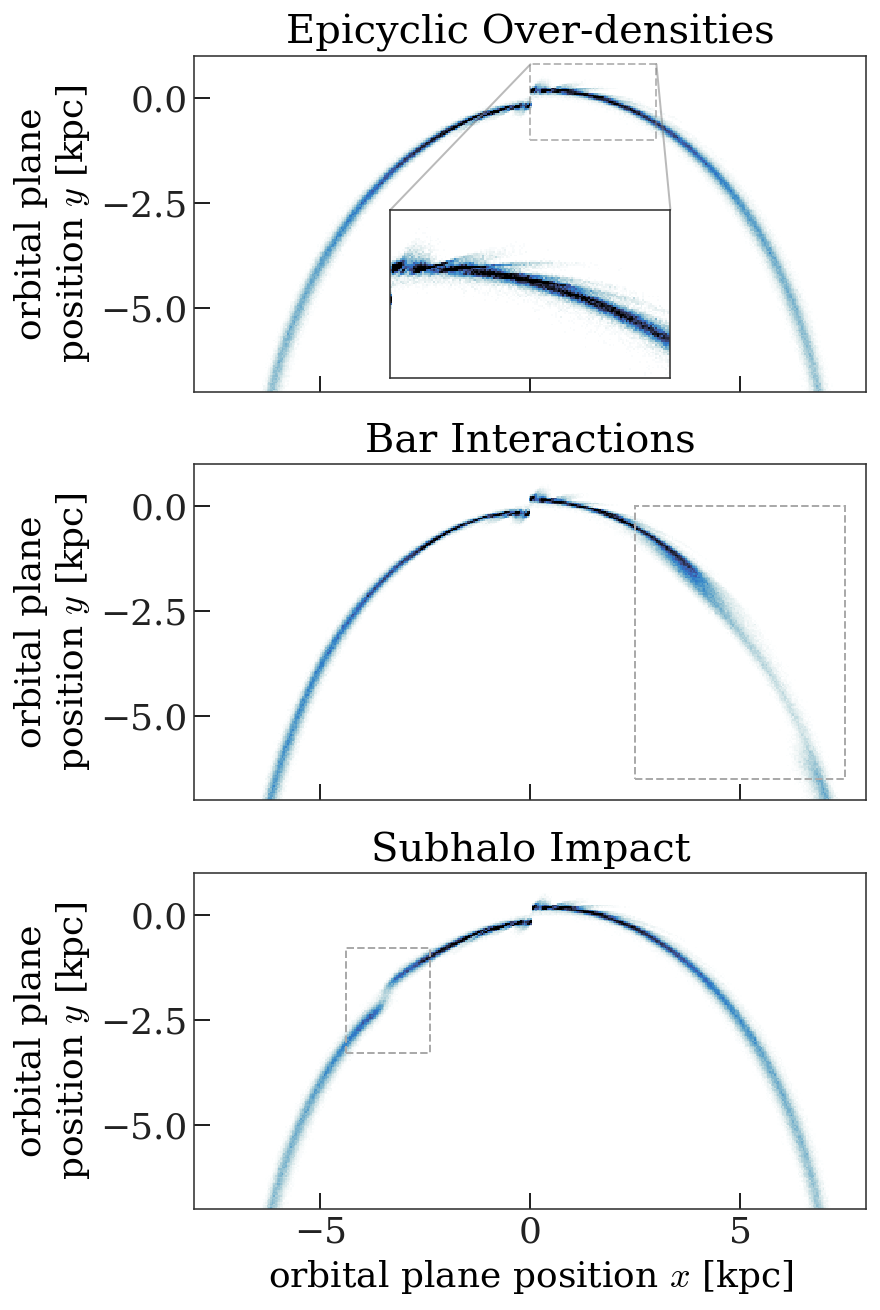

In [273]:
filenames = [
    "../data/stream-sims/stream-epicycles.h5",
    "../data/stream-sims/stream-bar.h5",
    "../data/stream-sims/stream-subhalo.h5"
]
names = ["Epicyclic Over-densities", "Bar Interactions", r"Subhalo Impact"]
dx = 0.040  # pixel size in kpc
cmap = cmr.arctic_r

fig, axes = plt.subplots(
    len(filenames), 1, 
    figsize=(6, 3 * len(filenames)), 
    layout="constrained",
    sharex=True, 
    sharey=True
)
    
for i, (ax, filename, title) in enumerate(zip(axes, filenames, names)):
    with h5py.File(filename, mode="r") as f:
        stream = gd.PhaseSpacePosition.from_hdf5(f["stream"])
        stream = gd.mockstream.MockStream(
            pos=stream.pos, 
            vel=stream.vel, 
            release_time=f["stream/release_time"][:] * u.Myr
        )
        prog = gd.PhaseSpacePosition.from_hdf5(f["prog"])

    ang = np.squeeze(np.arctan2(prog.z, prog.x))
    R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))

    H, xe, ye = np.histogram2d(
        stream_rot.y.value,
        stream_rot.x.value - prog_rot.x.value,
        bins=(np.arange(-8, 8 + 1e-3, dx), np.arange(-7, 1 + 1e-3, dx)),
    )
    H /= dx**2
    # norm = mpl.colors.AsinhNorm(linear_width=5, vmin=0.5, vmax=np.nanpercentile(H[H > 0], 99))
    norm = mpl.colors.Normalize(vmin=0, vmax=np.nanpercentile(H[H > 0], 99))
    
    ax.pcolormesh(xe, ye, H.T, cmap=cmap, norm=norm)
    
    if i == 0:
        zoom_dx = dx / 2
        H, xe, ye = np.histogram2d(
            stream_rot.y.value,
            stream_rot.x.value - prog_rot.x.value,
            bins=(np.arange(-8, 8 + 1e-3, zoom_dx), np.arange(-7, 1 + 1e-3, zoom_dx)),
        )
        H /= zoom_dx**2
        
        ax_inset = ax.inset_axes(
            [0.5 - 0.55/2, 0.042, 0.55, 0.5],
            xlim=(0, 3),
            ylim=(-1, 0.8),
            xticks=[],
            yticks=[],
            xticklabels=[],
            yticklabels=[],
        )
        ax_inset.set_aspect("equal")
        ax_inset.pcolormesh(xe, ye, H.T, cmap=cmap, norm=norm, rasterized=True)
        ax.indicate_inset_zoom(ax_inset, edgecolor="#777777", linestyle='--')
        
    elif i == 1:
        rect = mpl.patches.Rectangle(
            (2.5, -6.5), width=5, height=6.5, 
            facecolor='none', edgecolor='#aaaaaa', linewidth=1, linestyle='--'
        )
        ax.add_patch(rect)
    
    elif i == 2:
        rect = mpl.patches.Rectangle(
            (-4.4, -3.3), width=2, height=2.5, 
            facecolor='none', edgecolor='#aaaaaa', linewidth=1, linestyle='--'
        )
        ax.add_patch(rect)
    
    ax.set(
        xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), 
        aspect=1.
    )
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("orbital plane\nposition $y$ [kpc]", fontsize=18)

axes[-1].set_xlabel("orbital plane position $x$ [kpc]", fontsize=18)
# cbar = fig.colorbar(ax=axes[-1], orientiation="horizontal")

fig.savefig("../tex/figures/sim-stream-structure.pdf", dpi=250)

In [186]:
# with h5py.File("../data/stream-sims/stream-epicycles.h5", mode="r") as f:
with h5py.File("../data/stream-sims/stream-bar.h5", mode="r") as f:
# with h5py.File("../data/stream-sims/stream-subhalo.h5", mode="r") as f:
# with h5py.File("../data/stream-sims/stream-sgr.h5", mode="r") as f:
    stream = gd.PhaseSpacePosition.from_hdf5(f["stream"])
    stream = gd.mockstream.MockStream(
        pos=stream.pos, 
        vel=stream.vel, 
        release_time=f["stream/release_time"][:] * u.Myr
    )
    prog = gd.PhaseSpacePosition.from_hdf5(f["prog"])
    
ang = np.squeeze(np.arctan2(prog.z, prog.x))
R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))

In [187]:
mw = gp.MilkyWayPotential2022()
prog_orbitf = mw.integrate_orbit(prog, dt=0.5*u.Myr, t1=6*u.Gyr, t2=6.2*u.Gyr)
prog_orbitb = mw.integrate_orbit(prog, dt=-0.5*u.Myr, t1=6*u.Gyr, t2=5.8*u.Gyr)

_rep = coord.concatenate_representations((prog_orbitb.data[::-1], prog_orbitf.data))
prog_orbit = gd.Orbit(
    _rep.without_differentials(),
    _rep.differentials['s'],
    t=np.concatenate((prog_orbitb.t[::-1], prog_orbitf.t))
)

_rep_rot = _rep.transform(R)
prog_orbit_rot = gd.Orbit(
    _rep_rot.without_differentials(),
    _rep_rot.differentials['s'],
    t=np.concatenate((prog_orbitb.t[::-1], prog_orbitf.t))
)

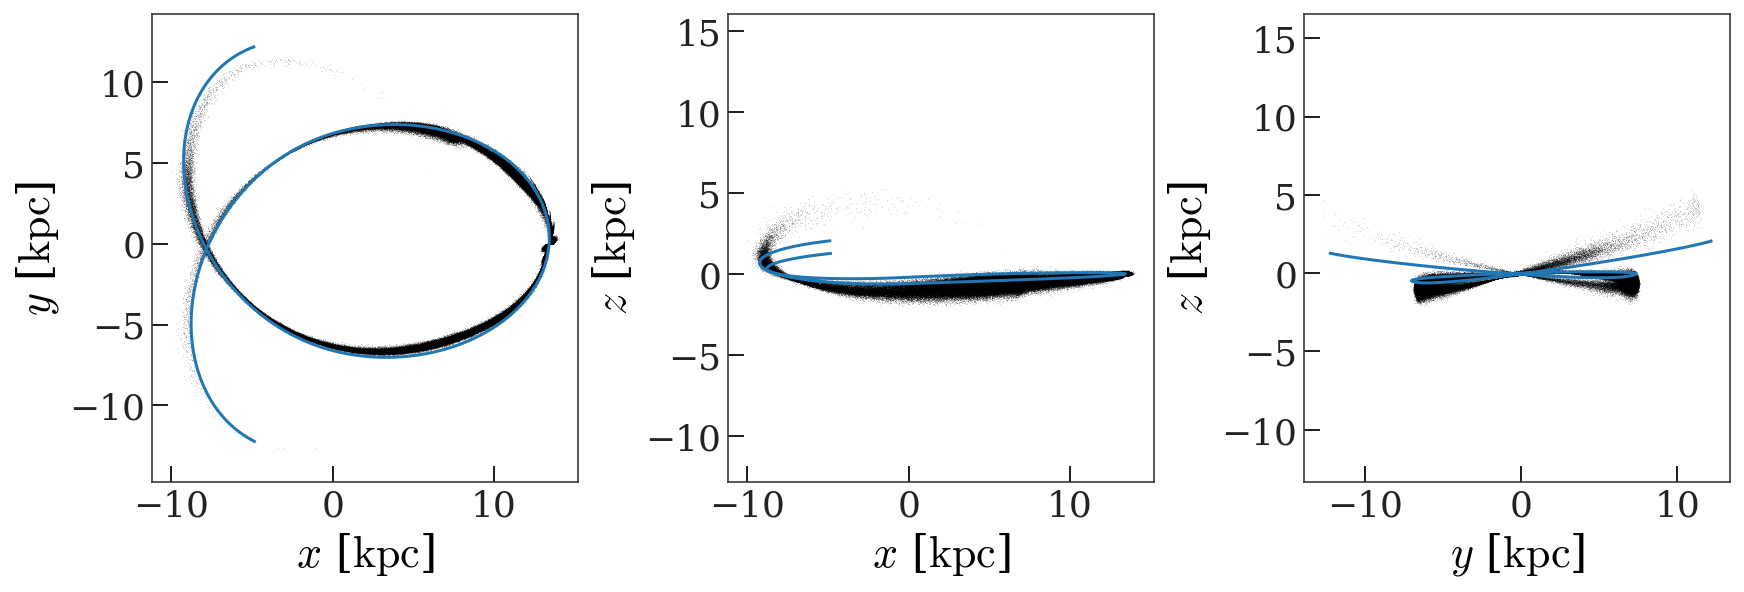

In [188]:
fig = stream_rot.plot(plot_function=plt.plot, ls="none", ms=1., alpha=0.2);
prog_orbit_rot.plot(axes=fig.axes);

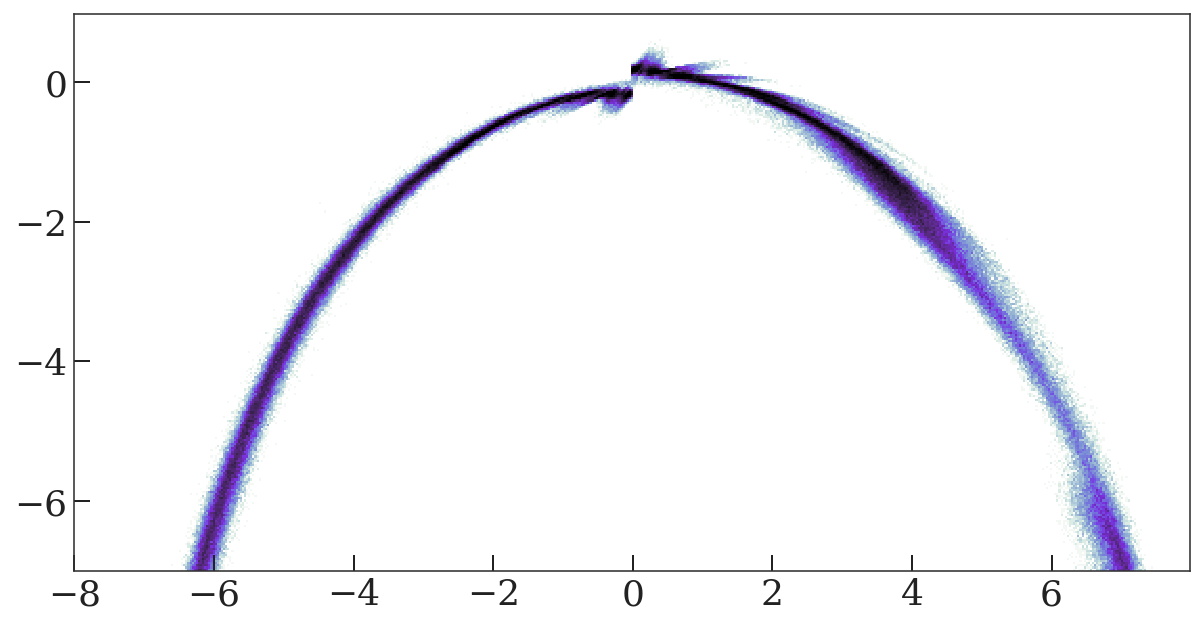

In [189]:
dx = 0.03

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
H, xe, ye = np.histogram2d(
    stream_rot.y.value,
    stream_rot.x.value - prog_rot.x.value,
    bins=(np.arange(-8, 8 + 1e-3, dx), np.arange(-7, 1 + 1e-3, dx)),
)
# ax.pcolormesh(xe, ye, H.T, cmap=cmr.amethyst_r, vmin=0, vmax=np.nanpercentile(H[H > 0], 84))
# ax.pcolormesh(xe, ye, H.T, cmap=cmr.amethyst_r, norm=mpl.colors.LogNorm(vmin=0.5, vmax=np.nanpercentile(H[H > 0], 99)))
ax.pcolormesh(xe, ye, H.T, cmap=cmr.amethyst_r, norm=mpl.colors.AsinhNorm(linear_width=5, vmin=0.5, vmax=np.nanpercentile(H[H > 0], 99)))

# ax.plot(prog_orbit_rot.y.value, prog_orbit_rot.x.value - prog_rot.x.value, marker='')
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), aspect=1.);

In [25]:
pot = gp.MilkyWayPotential2022()
sim_time = 6 * u.Gyr
prog_wf = gd.PhaseSpacePosition(
    [6.0, 0, 12] * u.kpc, [0, -130, -10] * u.km / u.s
)
mockstream_kwargs = {
    "prog_mass": 5e4 * u.Msun,
    "dt": 1 * u.Myr,
    "release_every": 4,
    "n_particles": 1,
}
rng = np.random.default_rng(seed=42)
df = gd.FardalStreamDF(gala_modified=False, random_state=rng)

In [36]:
# Omega = 40.35 * u.km / u.s / u.kpc
Omega = 40.0 * u.km / u.s / u.kpc
sign = -1.0
bar_frame = gp.ConstantRotatingFrame(Omega * [0, 0, sign], units=galactic)

mw_barred = gp.CCompositePotential()
mw_barred["bar"] = gp.LongMuraliBarPotential(
    m=1e10 * u.Msun,
    a=3.0 * u.kpc,
    b=0.75 * u.kpc,
    c=0.5 * u.kpc,
    alpha=-27 * u.deg,
    units=galactic,
)
mw_barred["disk"] = pot["disk"].replicate(m=4.155e10 * u.Msun)
mw_barred["halo"] = pot["halo"]
mw_barred["nucleus"] = pot["nucleus"]
assert u.allclose(
    mw_barred.circular_velocity([8.0, 0, 0]),
    pot.circular_velocity([8.0, 0, 0]),
    atol=0.5 * u.km / u.s,
)

H = gp.Hamiltonian(mw_barred, bar_frame)

# Integrate the final prog position back in the barred potential:
prog_orbit = H.integrate_orbit(
    prog_wf, dt=-0.2, t1=0, t2=-sim_time, Integrator=gi.DOPRI853Integrator
)
prog_w0 = prog_orbit[-1]

gen = gd.MockStreamGenerator(df, H)
stream, prog = gen.run(prog_w0, t1=0, t2=sim_time, **mockstream_kwargs)

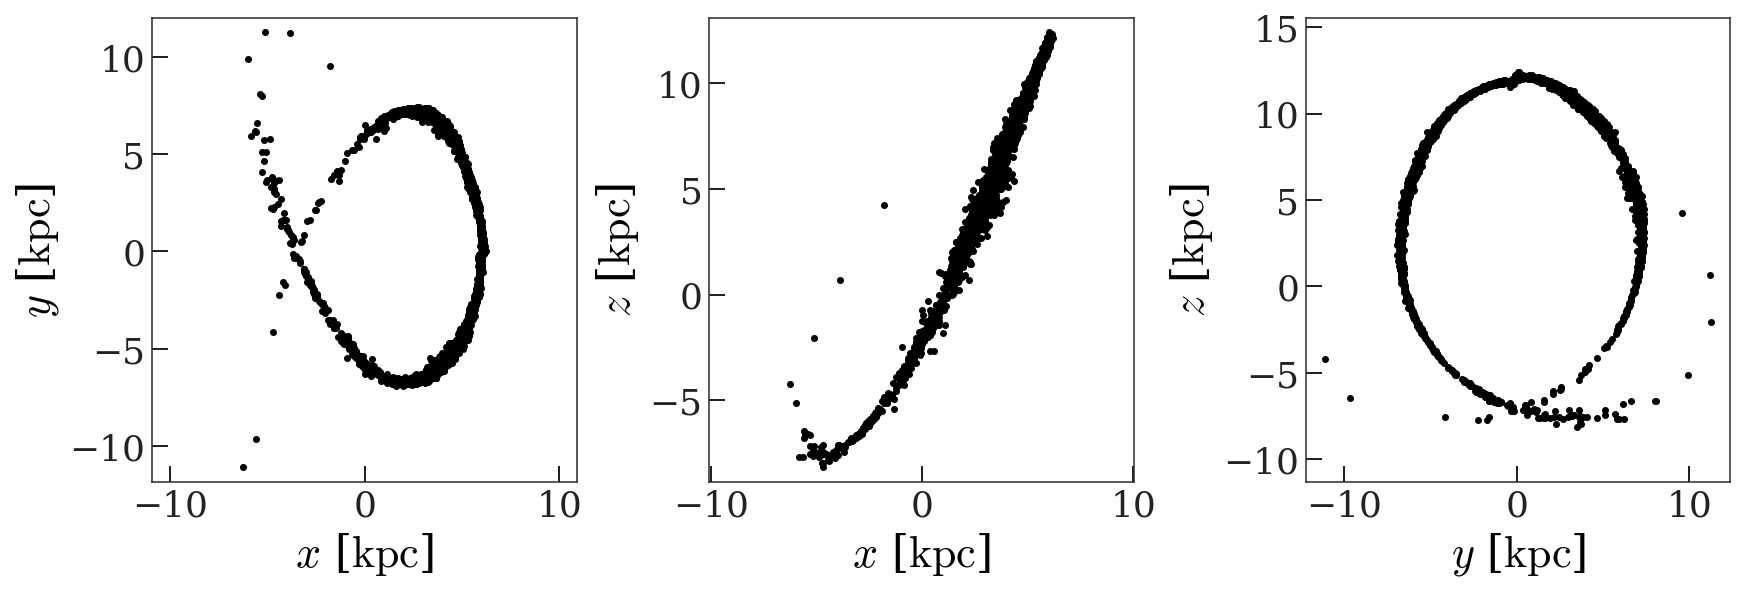

In [37]:
stream.plot();

In [38]:
ang = np.arctan2(prog.z, prog.x)[0]
R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))

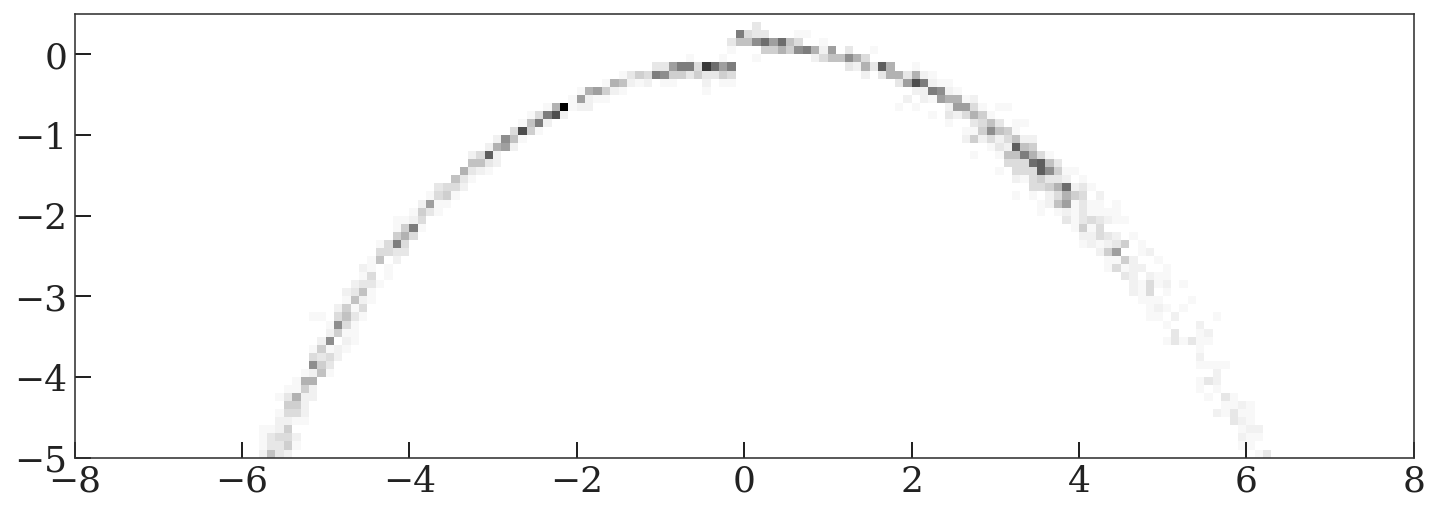

In [39]:
dx = 0.1

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
H, xe, ye = np.histogram2d(
    stream_rot.y.value,
    stream_rot.x.value - prog_rot.x.value,
    bins=(np.arange(-8, 8 + 1e-3, dx), np.arange(-5, 0.5 + 1e-3, dx)),
)
ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()));

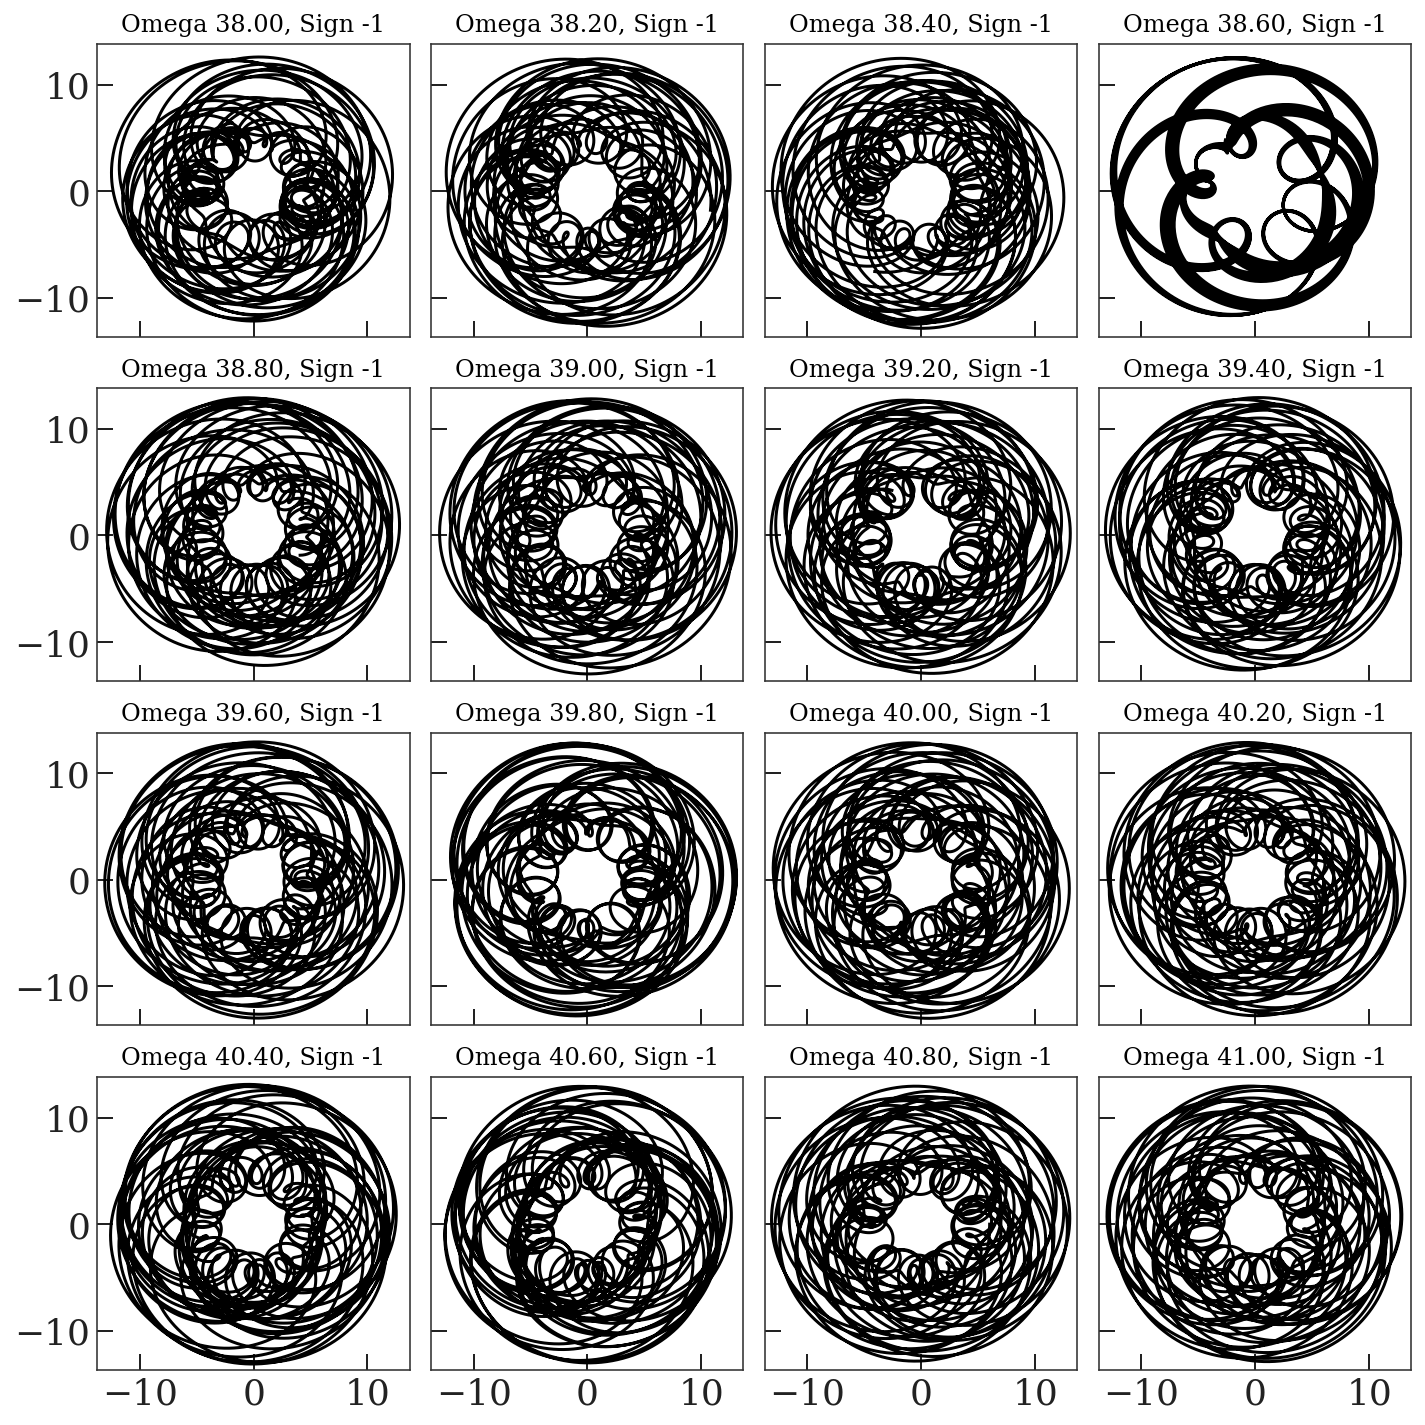

In [31]:
prog_wf = gd.PhaseSpacePosition(
    [6.0, 0, 12] * u.kpc, [0, -130, -10] * u.km / u.s
)

fig, axes = plt.subplots(4, 4, figsize=(10, 10), layout="tight", sharex=True, sharey=True)
i = 0
for Omega in np.round(np.linspace(38, 41, 16), 2) * u.km/u.s/u.kpc:
    for sign in [-1]:
        ax = axes.flat[i]
        bar_frame = gp.ConstantRotatingFrame(Omega * [0, 0, sign], units=galactic)
        
        H = gp.Hamiltonian(mw_barred, bar_frame)
        orbit_bar_frame = H.integrate_orbit(prog_wf, dt=-1, n_steps=8000)
        
        # orbit_bar_frame = orbit.to_frame(bar_frame)
        orbit_bar_frame.plot(['x', 'y'], axes=[ax], auto_aspect=False, labels=None);
        ax.set_title(f"Omega {Omega.value:.2f}, Sign {sign}", fontsize=12)
        i += 1

Phase-space position motivated by Pal 5:

In [2]:
# _c = coord.SkyCoord.from_name("Pal 5")

# allstar = at.Table.read("/Users/apricewhelan/data/APOGEE/DR17/allStarLite-dr17-synspec_rev1.fits")

# allstar_c = coord.SkyCoord(allstar["RA"], allstar["DEC"], unit=u.deg)
# mask = (
#     (allstar_c.separation(_c) < 0.5 * u.deg)
#     & (allstar["GAIAEDR3_PMRA"] < -2) & (allstar["GAIAEDR3_PMRA"] > -4)
#     & (allstar["GAIAEDR3_PMDEC"] < -2) & (allstar["GAIAEDR3_PMDEC"] > -4)
# )
# mask.sum()

# # plt.errorbar(
# #     allstar["GAIAEDR3_PMRA"][mask],
# #     allstar["VHELIO_AVG"][mask],
# #     allstar["VERR"][mask],
# #     ls='none'
# # )
# # plt.xlim(-4, -2)
# # # plt.ylim(-4, -2)

# rv = allstar["VHELIO_AVG"][mask]
# rv_err = allstar["VERR"][mask]
# rv = np.sum(rv / rv_err**2) / np.sum(1 / rv_err**2)
# rv

# c = coord.SkyCoord(
#     ra=_c.ra,
#     dec=_c.dec,
#     distance=20.6*u.kpc,
#     pm_ra_cosdec=-2.75 * u.mas/u.yr,
#     pm_dec=-2.69 * u.mas/u.yr,
#     radial_velocity=rv * u.km/u.s
# )
# w0 = gd.PhaseSpacePosition(c.transform_to(galcen_frame).data)
pal5_w0 = gd.PhaseSpacePosition(
    [6.10666435, 0.21330404, 14.76810429] * u.kpc,
    [-47.76135071, -124.34059763, -11.96646005] * u.km / u.s,
)

Pal 5 galcen radius: 16 kpc, velocity ~ 140 km/s, ecc ~ 0.38

In [2]:
import streamsubhalosim as sss

In [220]:
pot = gp.MilkyWayPotential2022()
sim_time = 6 * u.Gyr
prog_wf = gd.PhaseSpacePosition(
    [6.0, 0, 12] * u.kpc, [0, -130, -10] * u.km / u.s
)
mockstream_kwargs = {
    "prog_mass": 5e4 * u.Msun,
    "dt": 2 * u.Myr,
    "release_every": 10,
    "n_particles": 1,
}
rng = np.random.default_rng(seed=42)
df = gd.FardalStreamDF(gala_modified=False, random_state=rng)

In [221]:
from astropy.cosmology import Planck18
# Using the Moliné et al. 2017 fitting formula for the concentration-mass relation
def c200(M200, xsub):
    c0 = 19.9
    a = [-0.195, 0.089, 0.089]
    b = -0.54
    h = Planck18.h
    return (
        c0
        * (
            1
            + np.sum(
                [
                    (a[i] * np.log10(M200 / (1e8 * u.Msun) * h)) ** (i + 1)
                    for i in range(3)
                ]
            )
        )
        * (1 + b * np.log10(xsub))
    )

In [251]:
M200 = 5e9 * u.Msun
subhalo_pot = gp.NFWPotential.from_M200_c(
    M200, c=2 * c200(M200, xsub=15.0 / 250), units=galactic
)
subhalo_pot.parameters['r_s']

<Quantity 0.37848087 kpc>

In [223]:
t_post_impact = 0.3 * u.Gyr
sim = sss.StreamSubhaloSimulation(
    pot,
    prog_wf,
    M_stream=mockstream_kwargs["prog_mass"],
    t_pre_impact=sim_time - t_post_impact,
    t_post_impact=t_post_impact,
    df=df,
    dt=1 * u.Myr,
    release_every=10,
    n_particles=1
)

_, (init_stream, init_prog) = sim.run_init_stream()

# Find an impact site at the final stream time:
impact_site = sim.get_impact_site(init_stream, init_prog, prog_dist=4 * u.kpc)

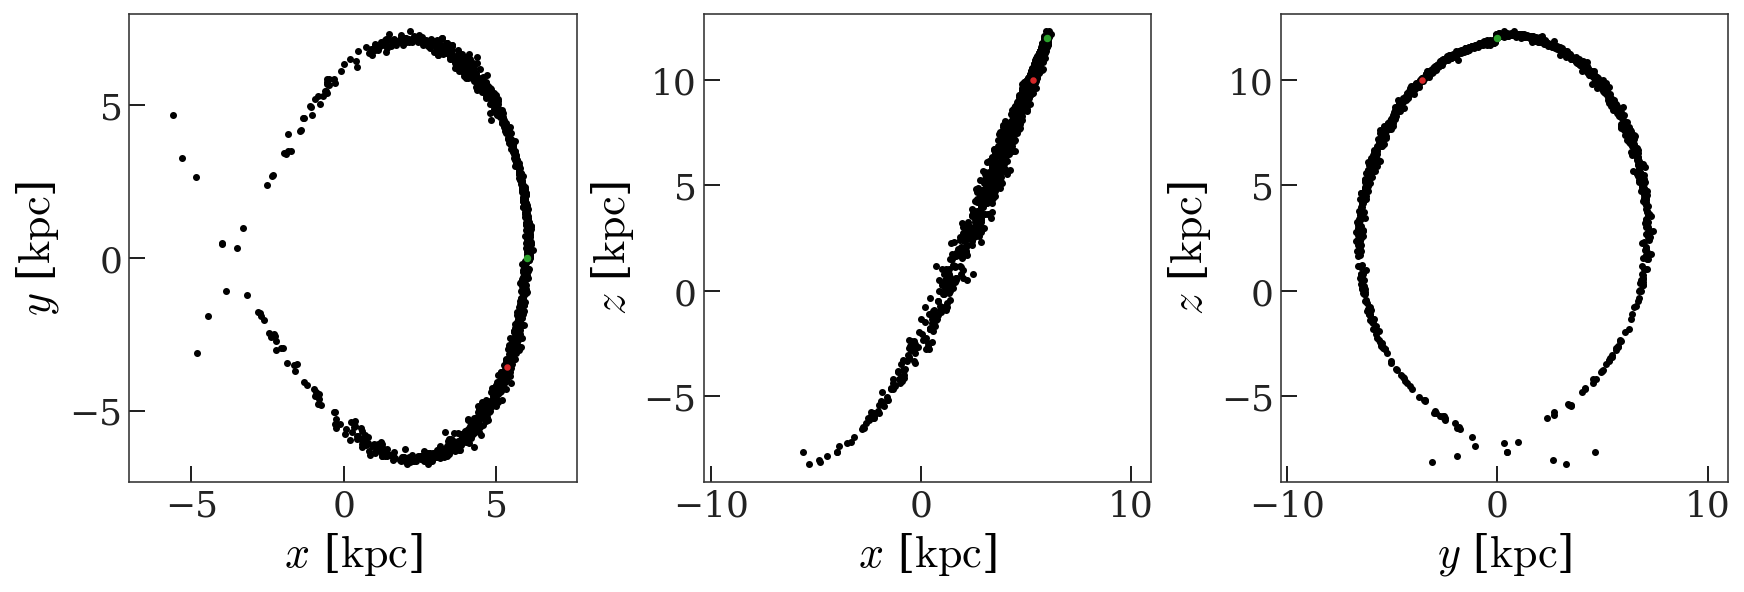

In [224]:
fig = init_stream.plot();
impact_site.plot(color='tab:red', s=20, axes=fig.axes);
prog_wf.plot(axes=fig.axes, color='tab:green', s=30);

In [246]:
# Rewind the impact site to the impact time:
impact_site_at_impact = sim.H.integrate_orbit(
    impact_site,
    dt=-sim.dt,
    t1=sim.t_pre_impact + sim.t_post_impact,
    t2=sim.t_pre_impact,
    Integrator=gi.DOPRI853Integrator,
)[-1]

# TODO: direct impact, arbitrary angles
subhalo_w0 = sss.get_subhalo_w0(
    impact_site_at_impact,
    b=5.0 * u.kpc,
    phi=90.0 * u.deg,
    vphi=-100 * u.km / u.s,
    vz=150 * u.km / u.s,
)

# Compute "buffer" time duration and timestep
# Buffer time is 32 times the crossing time:
BUFFER_N = 32
subhalo_dv = np.linalg.norm(subhalo_w0.v_xyz - impact_site.v_xyz)
subhalo_dx = subhalo_pot.parameters["r_s"]

# Minimum buffer time = 20 Myr
t_buffer_impact = np.round(
    (BUFFER_N * subhalo_dx / subhalo_dv).to(u.Myr), decimals=0
)
t_buffer_impact = np.max(u.Quantity([t_buffer_impact, 20 * u.Myr]))

# Minimum buffer time step = 0.05 Myr
impact_dt = np.round((t_buffer_impact / 256).to(u.Myr), decimals=1)
impact_dt = np.max(u.Quantity([impact_dt, 0.05 * u.Myr]))

In [247]:
stream, prog, final_t = sim.run_perturbed_stream(
    subhalo_w0, subhalo_pot, t_buffer_impact, impact_dt
)
print(f"final time: {final_t}")

final time: 6.0 Gyr


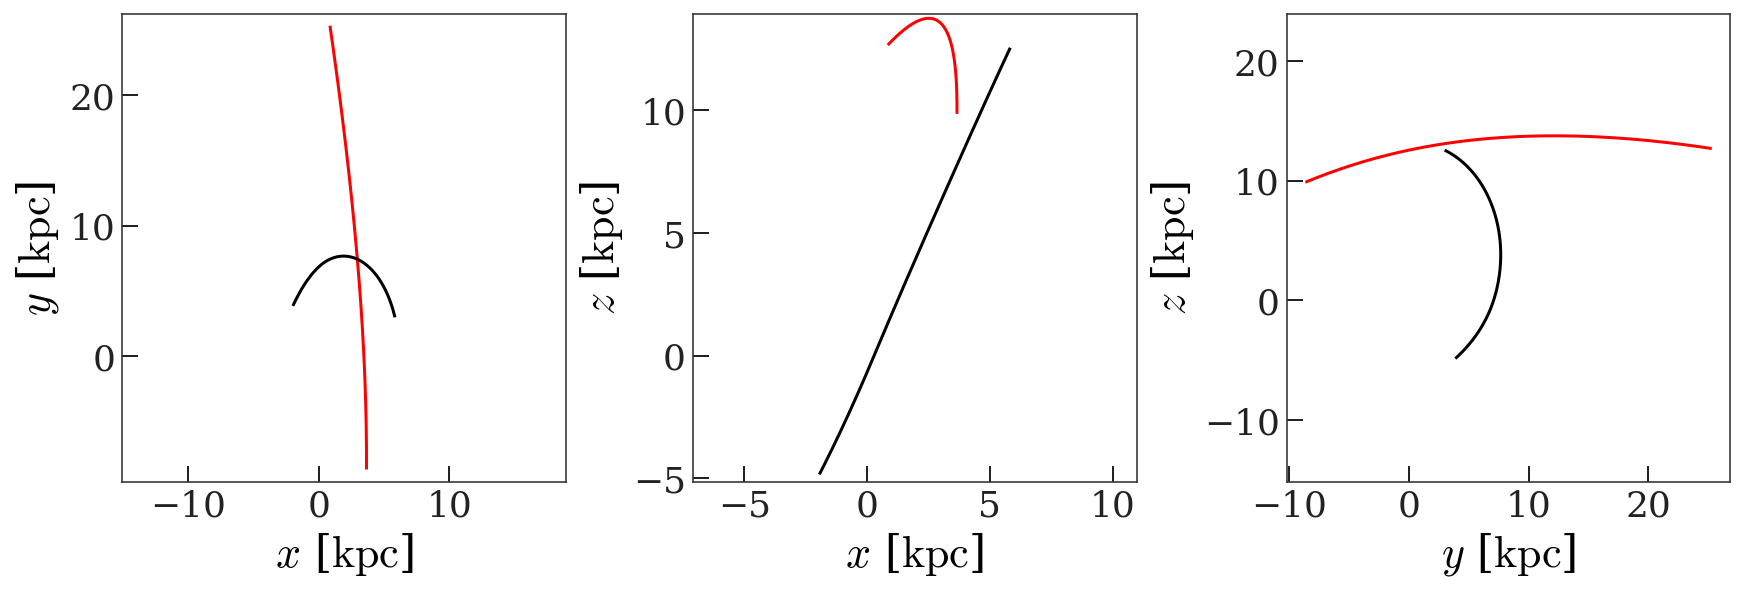

In [249]:
_subhalo_orbit = sim.H.integrate_orbit(subhalo_w0, dt=-0.5, t1=sim.t_pre_impact, t2=sim.t_pre_impact - t_buffer_impact)
_prog_orbit = sim.H.integrate_orbit(prog, dt=-0.5, t1=sim.t_pre_impact, t2=sim.t_pre_impact - t_buffer_impact)

fig = _subhalo_orbit.plot(color="r")
_prog_orbit.plot(axes=fig.axes, color="k");

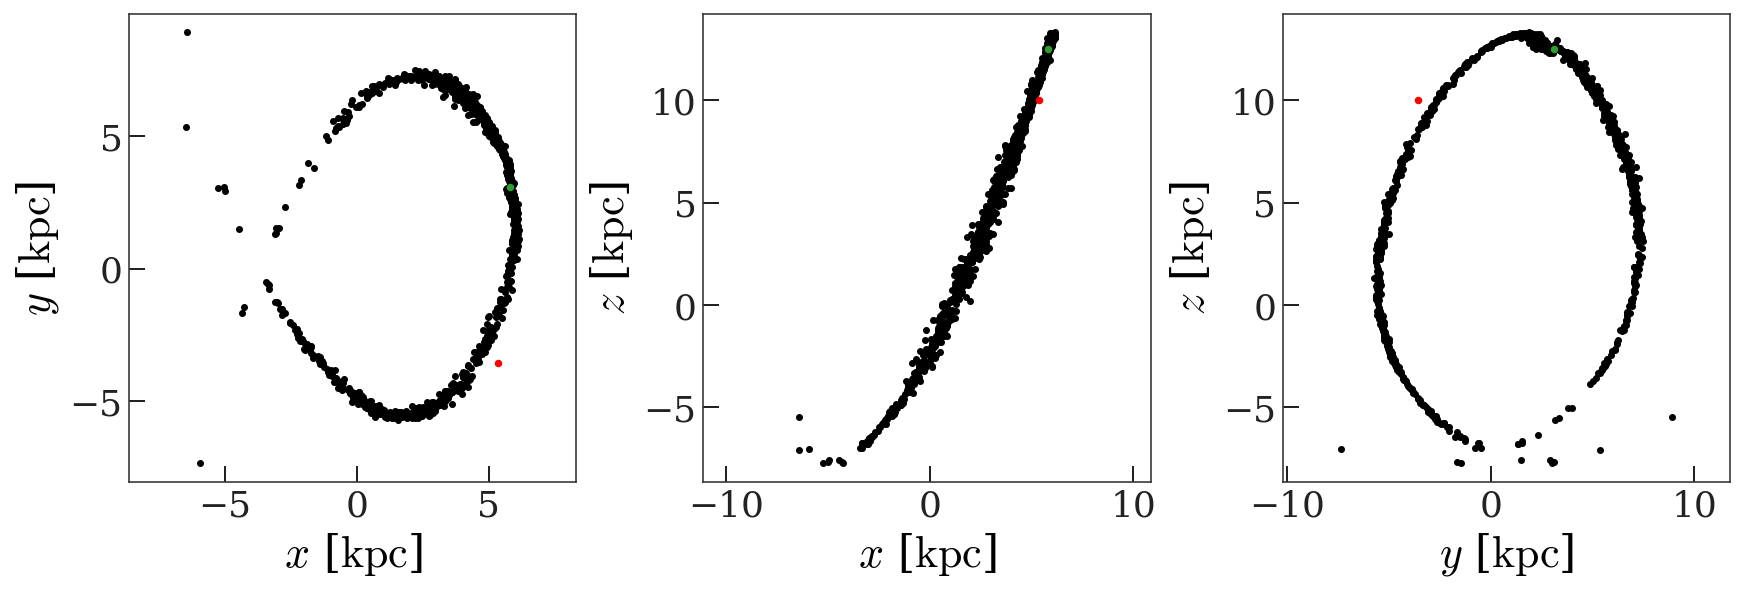

In [250]:
fig = stream.plot();
impact_site.plot(axes=fig.axes, color='r', s=30);
prog.plot(axes=fig.axes, color='tab:green', s=30);

In [238]:
ang = np.arctan2(prog.z, prog.x)
R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))

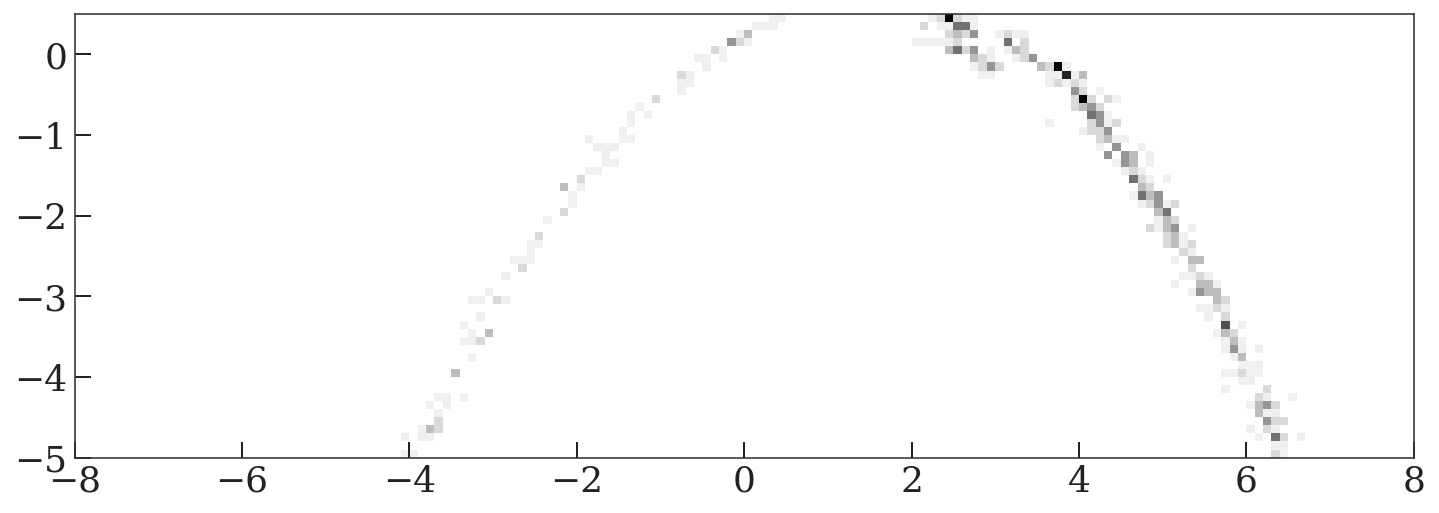

In [239]:
dx = 0.1

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
H, xe, ye = np.histogram2d(
    stream_rot.y.value,
    stream_rot.x.value - prog_rot.x.value,
    bins=(np.arange(-8, 8 + 1e-3, dx), np.arange(-5, 0.5 + 1e-3, dx)),
)
ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()));

In [77]:
w0 = gd.PhaseSpacePosition([6.0, 0, 12] * u.kpc, [0, -140, -12] * u.km / u.s)
# w0 = gd.PhaseSpacePosition([12.0, 0, 5] * u.kpc, [0, -100, 0] * u.km / u.s)
mw = gp.MilkyWayPotential2022()
# mw = gp.NFWPotential.from_M200_c(1e12*u.Msun, c=15., units=galactic)
orbit = mw.integrate_orbit(w0, dt=-1, t1=0, t2=-6 * u.Gyr)
orbit.pericenter(), orbit.apocenter(), orbit.eccentricity(), orbit.cylindrical.rho.min()

(<Quantity 6.86859507 kpc>,
 <Quantity 13.39385168 kpc>,
 <Quantity 0.32203695>,
 <Quantity 3.03362604 kpc>)

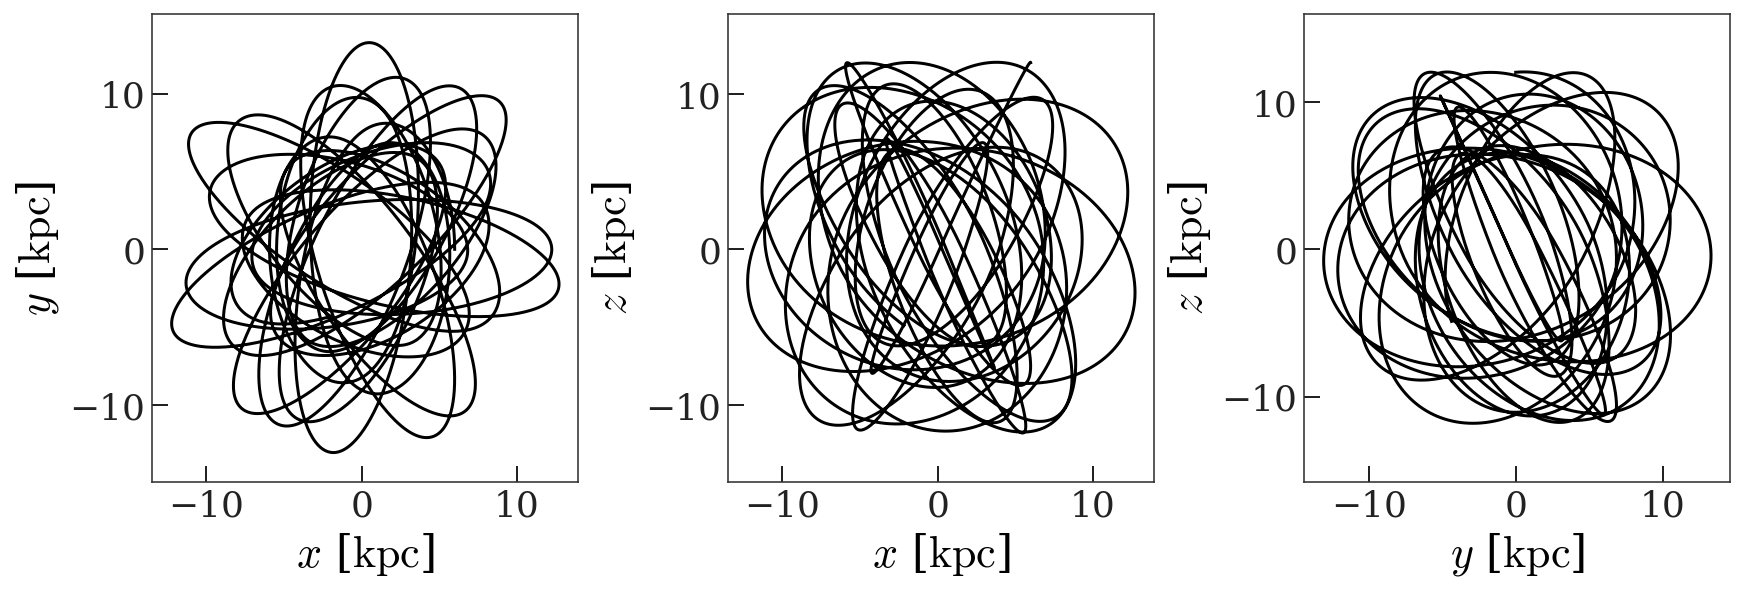

In [66]:
_ = orbit.plot()

# Epicycles:

In [34]:
df = gd.FardalStreamDF(gala_modified=False)
gen = gd.MockStreamGenerator(df, mw)
stream, prog = gen.run(
    w0,
    prog_mass=5e4 * u.Msun,
    dt=-0.1 * u.Myr,
    t1=0,
    t2=-5 * u.Gyr,
    release_every=1,
    n_particles=4,
)

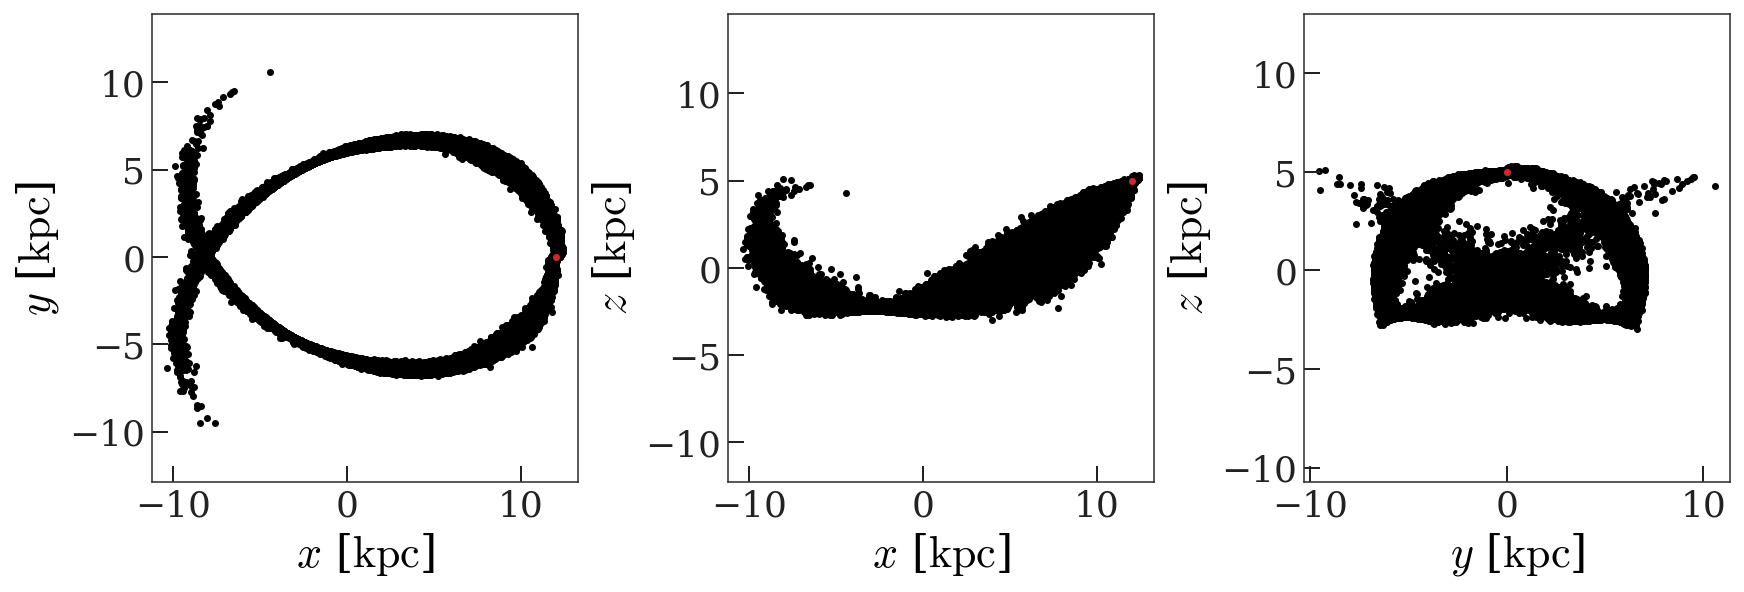

In [35]:
fig = stream.plot()
prog.plot(axes=fig.axes, color="tab:red");

In [106]:
ang = np.arctan2(prog.z, prog.x)[0]
R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
prog_rot.xyz.T

<Quantity [[ 1.3000000e+01, -2.1658543e-13, -8.8817842e-16]] kpc>

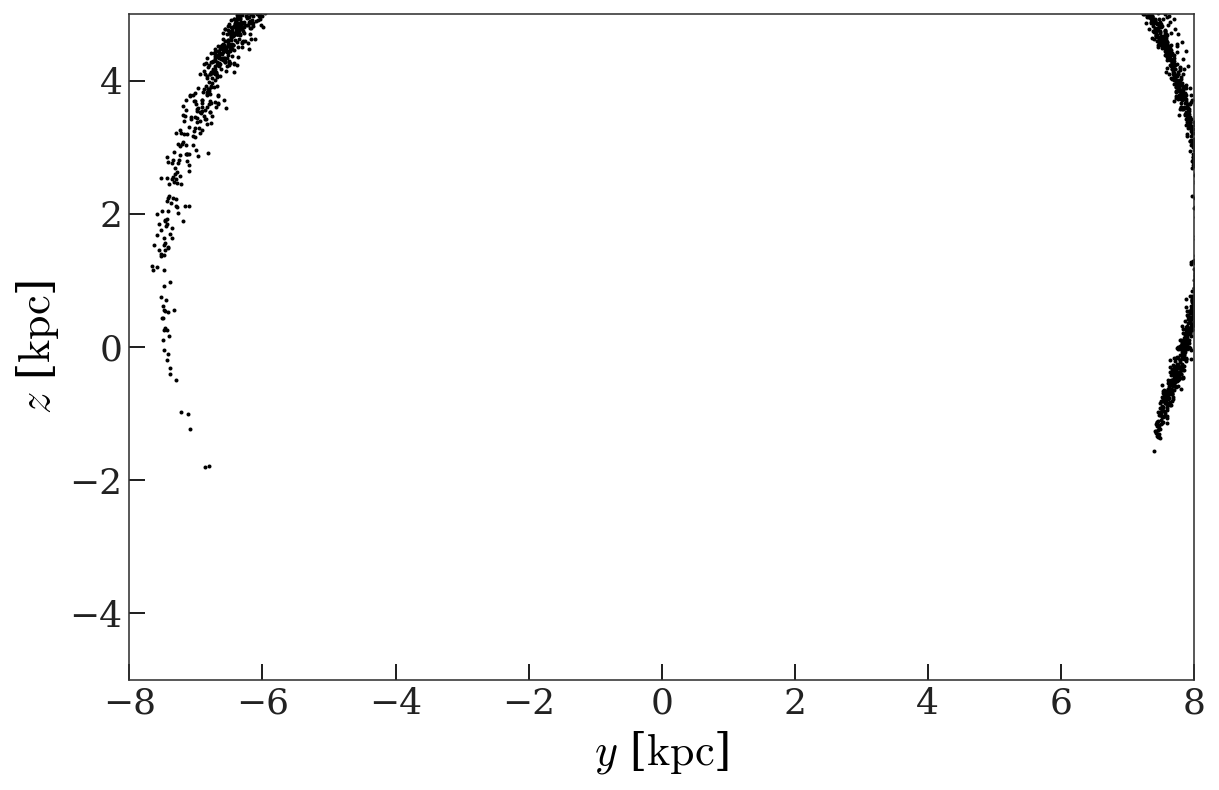

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
stream_rot[stream_rot.x > 0].plot(
    ["y", "z"],
    plot_function=plt.plot,
    marker="o",
    ms=2,
    mew=0,
    ls="none",
    auto_aspect=False,
    axes=[ax],
)
ax.set(xlim=(-8, 8), ylim=(-5, 5), aspect=True);

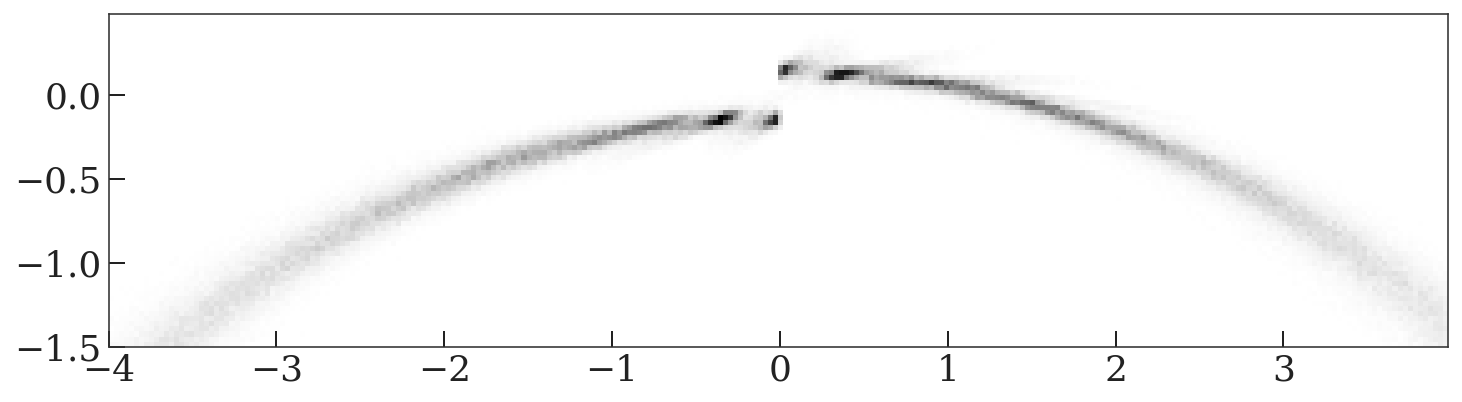

In [39]:
dx = 0.03

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
H, xe, ye = np.histogram2d(
    stream.y.value,
    stream.x.value - w0.x.value,
    bins=(np.arange(-4, 4 + 1e-3, dx), np.arange(-1.5, 0.5 + 1e-3, dx)),
)
ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), aspect=True);

In [43]:
# _dx = stream.x.value - w0.x.value
# _mask = (_dx > -1.5) & (_dx < 1.)
# plt.figure(figsize=(10, 4))
# plt.hist(stream.y.value[_mask], bins=np.arange(-3, 3, 0.05));

In [41]:
# dx = 0.025

# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# H, xe, ye = np.histogram2d(
#     stream_rot.y.value,
#     stream_rot.z.value,
#     bins=(np.arange(-4, 4 + 1e-3, dx), np.arange(-1.5, 0.5 + 1e-3, dx)),
# )
# ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
# ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), aspect=True);

# Bar

In [115]:
mw_barred = gp.CCompositePotential()

# mw_barred["bar"] = gp.LongMuraliBarPotential(
#     m=4e9 * u.Msun,
#     a=2. * u.kpc,
#     b=1*u.kpc,
#     c=0.75*u.kpc,
#     alpha=-27 * u.deg,
#     units=galactic
# )
# mw_barred["disk"] = mw["disk"]
mw_barred["bar"] = gp.LongMuraliBarPotential(
    m=1e10 * u.Msun,
    a=3.0 * u.kpc,
    b=0.75 * u.kpc,
    c=0.5 * u.kpc,
    alpha=-27 * u.deg,
    units=galactic,
)
mw_barred["disk"] = mw["disk"].replicate(m=4.155e10 * u.Msun)
mw_barred["halo"] = mw["halo"]
mw_barred["nucleus"] = mw["nucleus"]

In [116]:
mw_barred.circular_velocity([8., 0, 0]), mw.circular_velocity([8., 0, 0])

(<Quantity [229.52517401] km / s>, <Quantity [229.54613103] km / s>)

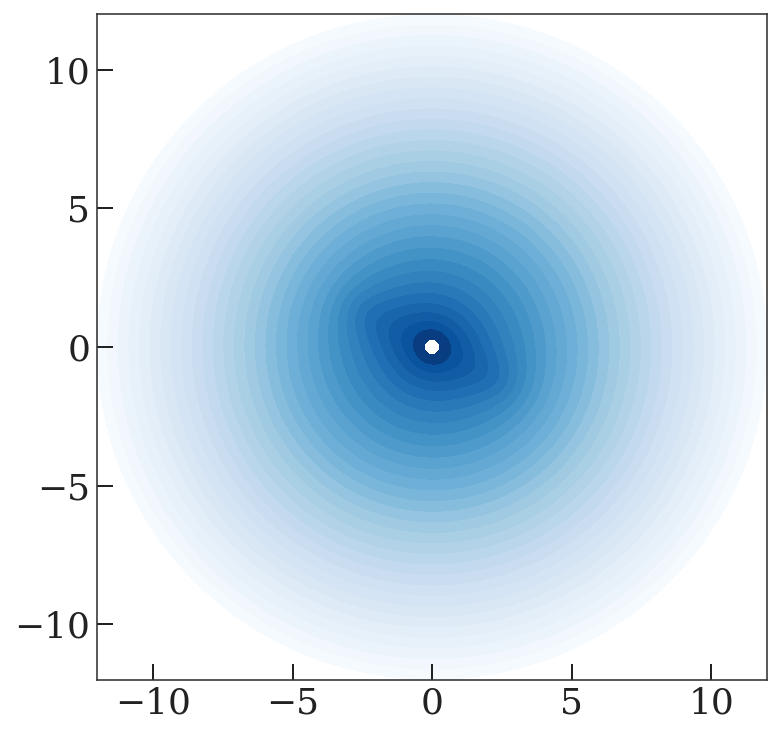

In [68]:
xxx = np.zeros((3, 128))
xxx[0] = np.linspace(1e-3, 12, xxx.shape[1])
dd = np.sort(mw_barred.density(xxx))[::4]
mw_barred.plot_density_contours(
    grid=(np.linspace(-12, 12, 128), np.linspace(-12, 12, 128), 0.0),
    levels=dd.value,
    norm=mpl.colors.LogNorm(),
);

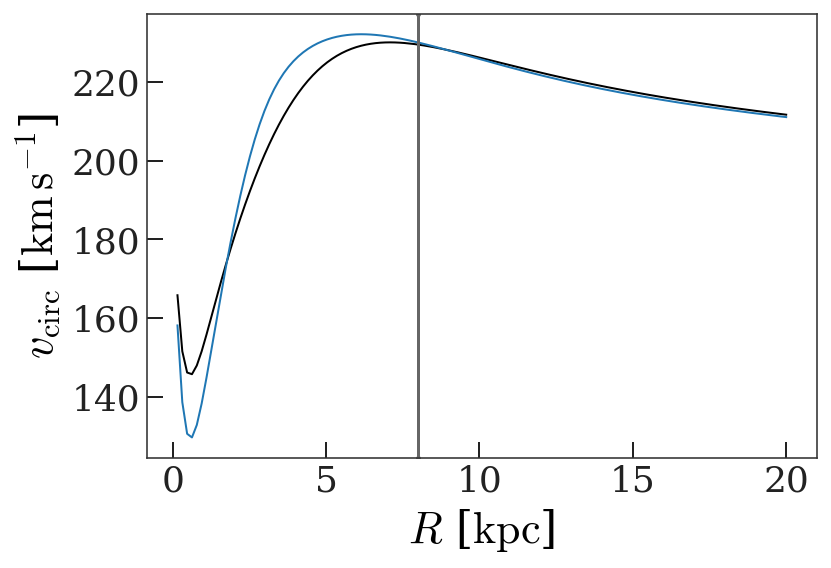

In [108]:
fig, ax = plt.subplots(figsize=(6, 4))
mw.plot_rotation_curve(np.linspace(0, 20, 128) * u.kpc, ax=ax)
mw_barred.plot_rotation_curve(np.linspace(0, 20, 128) * u.kpc, ax=ax)
ax.axvline(8.)

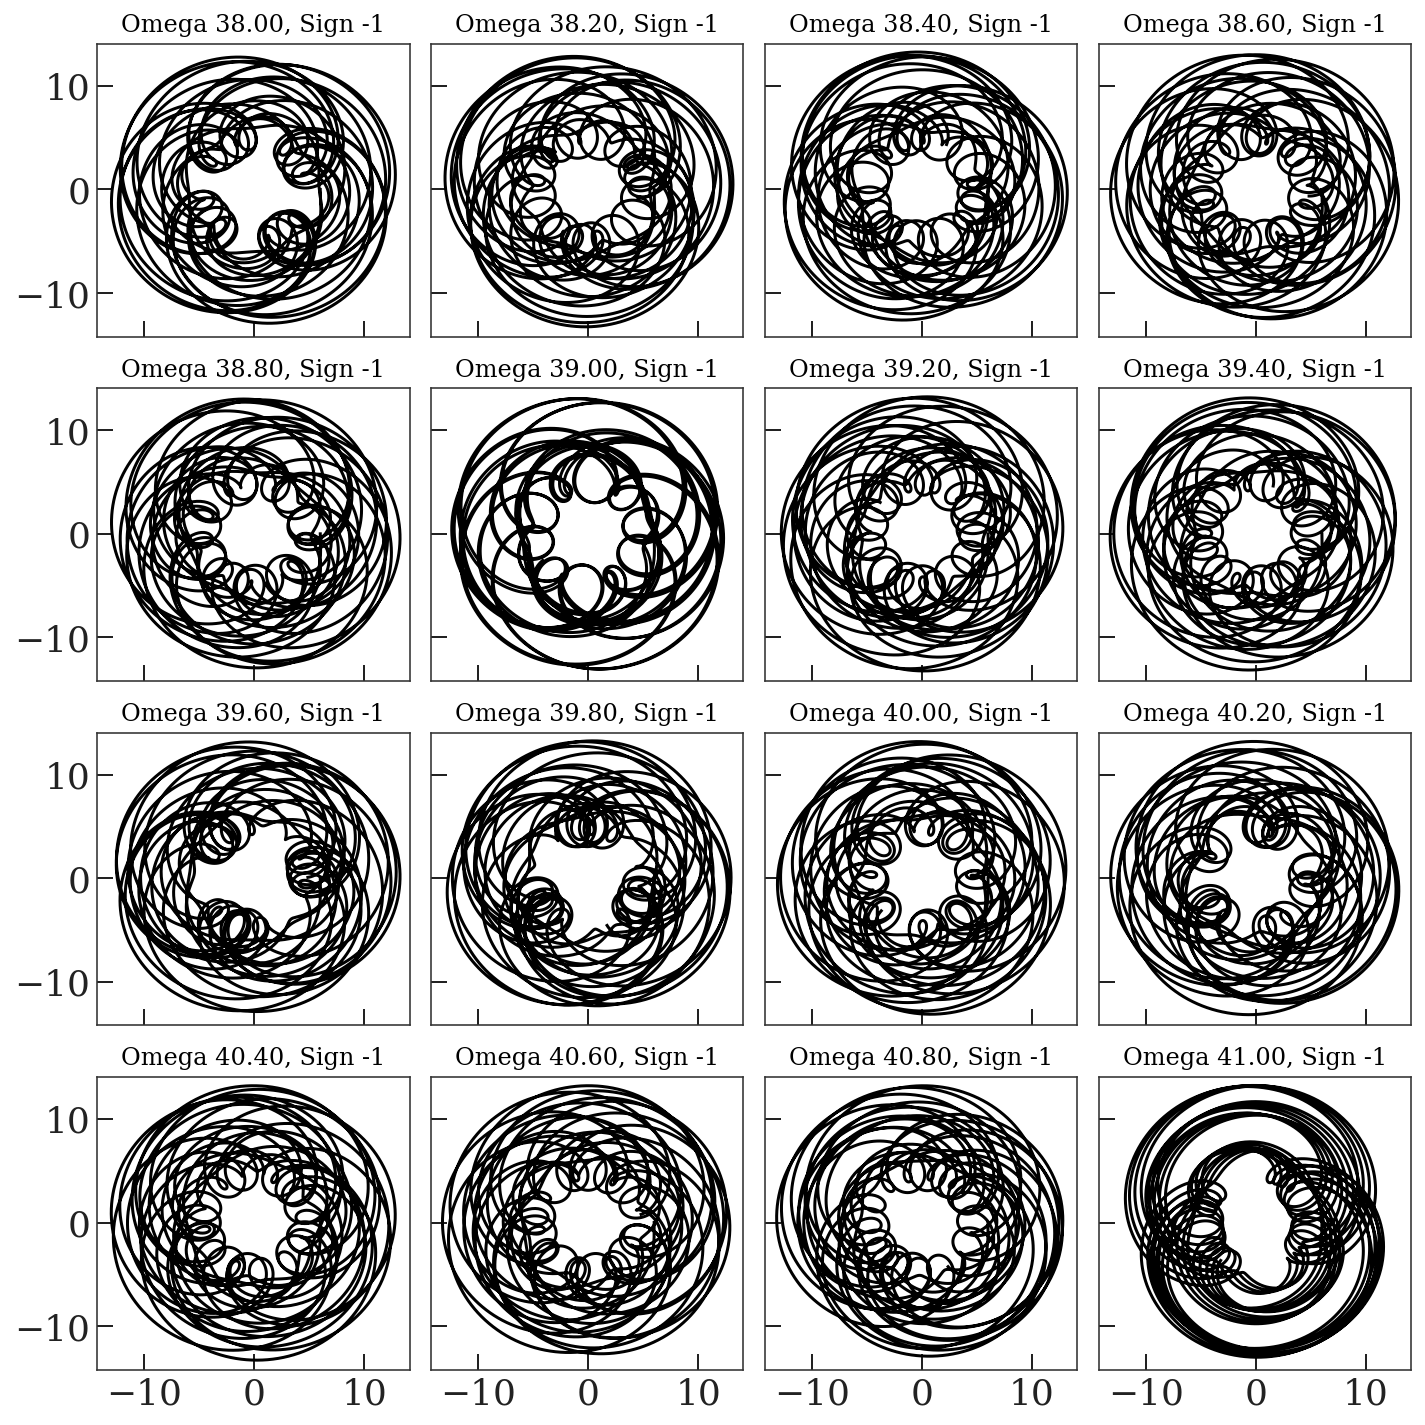

In [117]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), layout="tight", sharex=True, sharey=True)
i = 0
for Omega in np.round(np.linspace(38, 41, 16), 2) * u.km/u.s/u.kpc:
    for sign in [-1]:
        ax = axes.flat[i]
        bar_frame = gp.ConstantRotatingFrame(Omega * [0, 0, sign], units=galactic)
        orbit_bar_frame = orbit.to_frame(bar_frame)
        orbit_bar_frame.plot(['x', 'y'], axes=[ax], auto_aspect=False, labels=None);
        ax.set_title(f"Omega {Omega.value:.2f}, Sign {sign}", fontsize=12)
        i += 1

In [52]:
# w0 = gd.PhaseSpacePosition([13.0, 0, 0] * u.kpc, [0, -100, 0] * u.km / u.s)

In [78]:
Omega = 41.0 * u.km / u.s / u.kpc
sign = -1

df = gd.FardalStreamDF(gala_modified=False)
bar_frame = gp.ConstantRotatingFrame(Omega * [0, 0, sign], units=galactic)
H = gp.Hamiltonian(mw_barred, bar_frame)
gen = gd.MockStreamGenerator(df, H)
stream, _ = gen.run(
    w0,
    prog_mass=5e4 * u.Msun,
    dt=-1 * u.Myr,
    t1=0,
    t2=-5 * u.Gyr,
    release_every=1,
    n_particles=1,
)

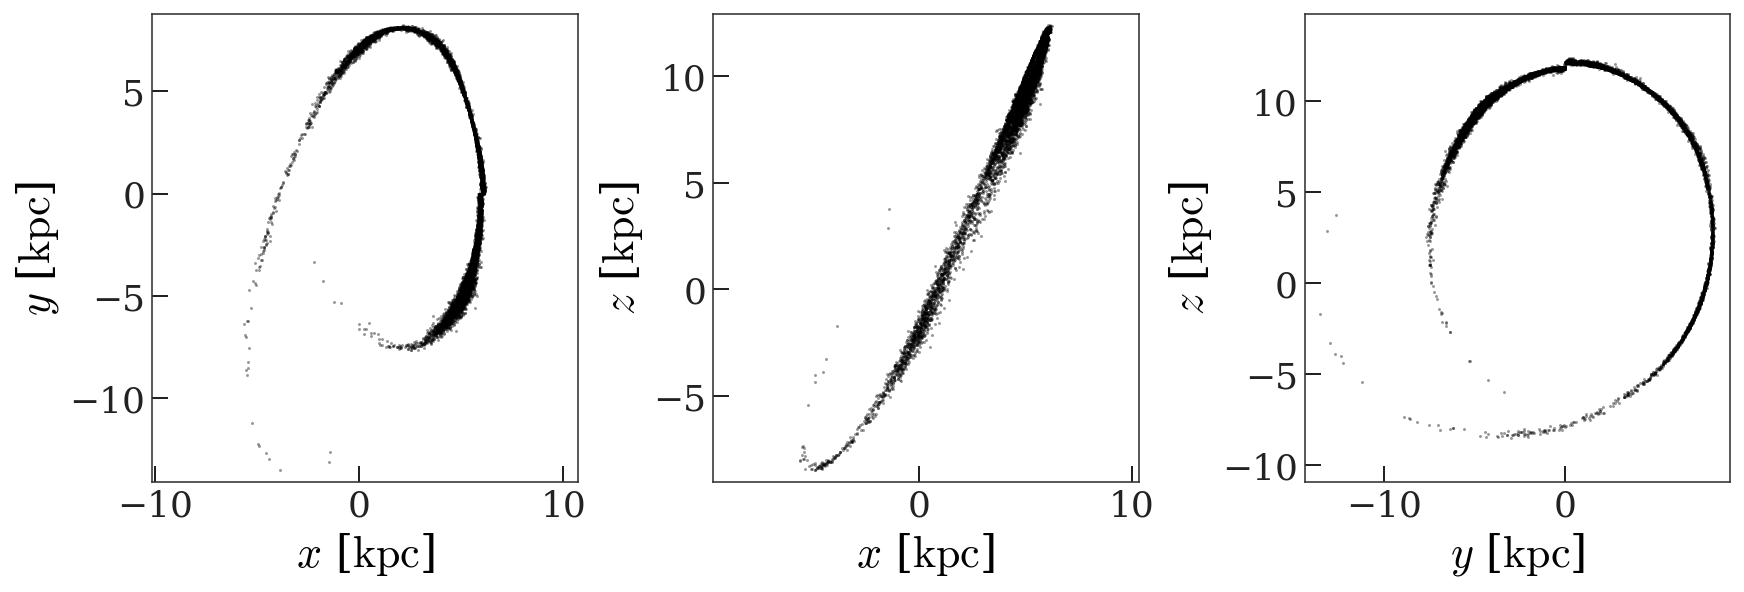

In [79]:
fig = stream.plot(s=1, alpha=0.4)

In [80]:
ang = np.arctan2(prog.z, prog.x)[0]
R = Rotation.from_euler("y", ang.to_value(u.deg), degrees=True).as_matrix()

stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
prog_rot.xyz.T

<Quantity [[ 1.3000000e+01, -2.1658543e-13, -8.8817842e-16]] kpc>

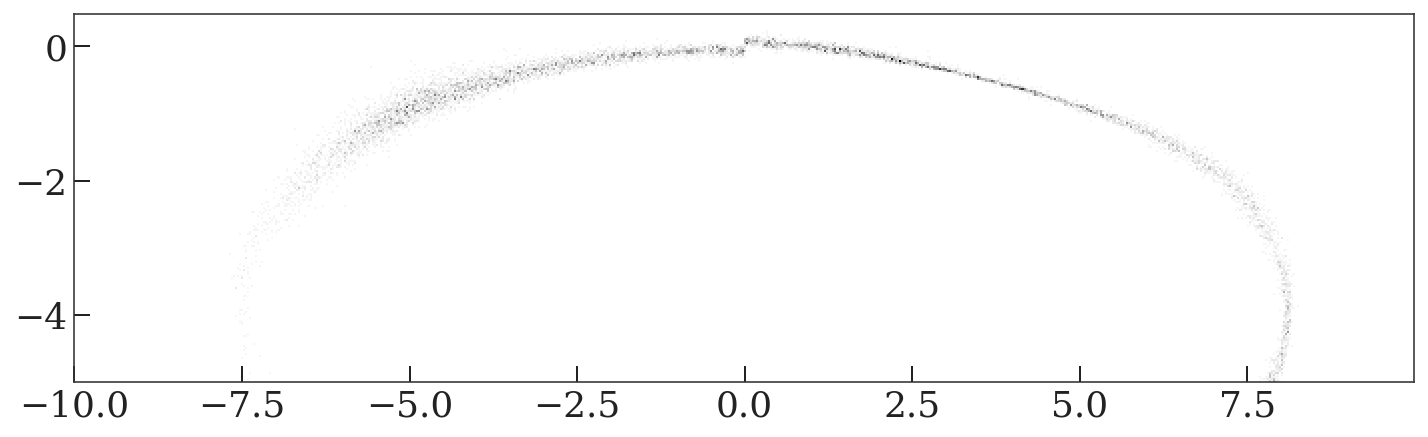

In [83]:
dx = 0.03

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
H, xe, ye = np.histogram2d(
    stream.y.value,
    stream.x.value - w0.x.value,
    bins=(np.arange(-10, 10 + 1e-3, dx), np.arange(-5, 0.5 + 1e-3, dx)),
)
ax.pcolormesh(xe, ye, H.T, cmap="Greys", vmin=0)
ax.set(xlim=(xe.min(), xe.max()), ylim=(ye.min(), ye.max()), aspect=True);

# Subhalo

In [87]:
# Using the Moliné et al. 2017 fitting formula
from astropy.cosmology import Planck18

def c200(M200, xsub):
    c0 = 19.9
    a = [-0.195, 0.089, 0.089]
    b = -0.54
    h = Planck18.h
    return (
        c0
        * (
            1
            + np.sum(
                [
                    (a[i] * np.log10(M200 / (1e8 * u.Msun) * h)) ** (i + 1)
                    for i in range(3)
                ]
            )
        )
        * (1 + b * np.log10(xsub))
    )

In [94]:
M200 = 5e6 * u.Msun
subhalo_pot = gp.NFWPotential.from_M200_c(M200, c=c200(M200, xsub=15. / 250), units=galactic)

In [95]:
import streamsubhalosim as sss

In [98]:
sim = sss.StreamSubhaloSimulation(
    mw, w0, M_stream=5e4*u.Msun, 
    t_pre_impact=4.6 * u.Gyr,
    t_post_impact=0.4 * u.Gyr
)

In [99]:
(init_stream, init_prog), _ = sim.run_init_stream()

In [103]:
impact_site = sim.get_impact_site(init_stream, init_prog, prog_dist=5 * u.kpc)

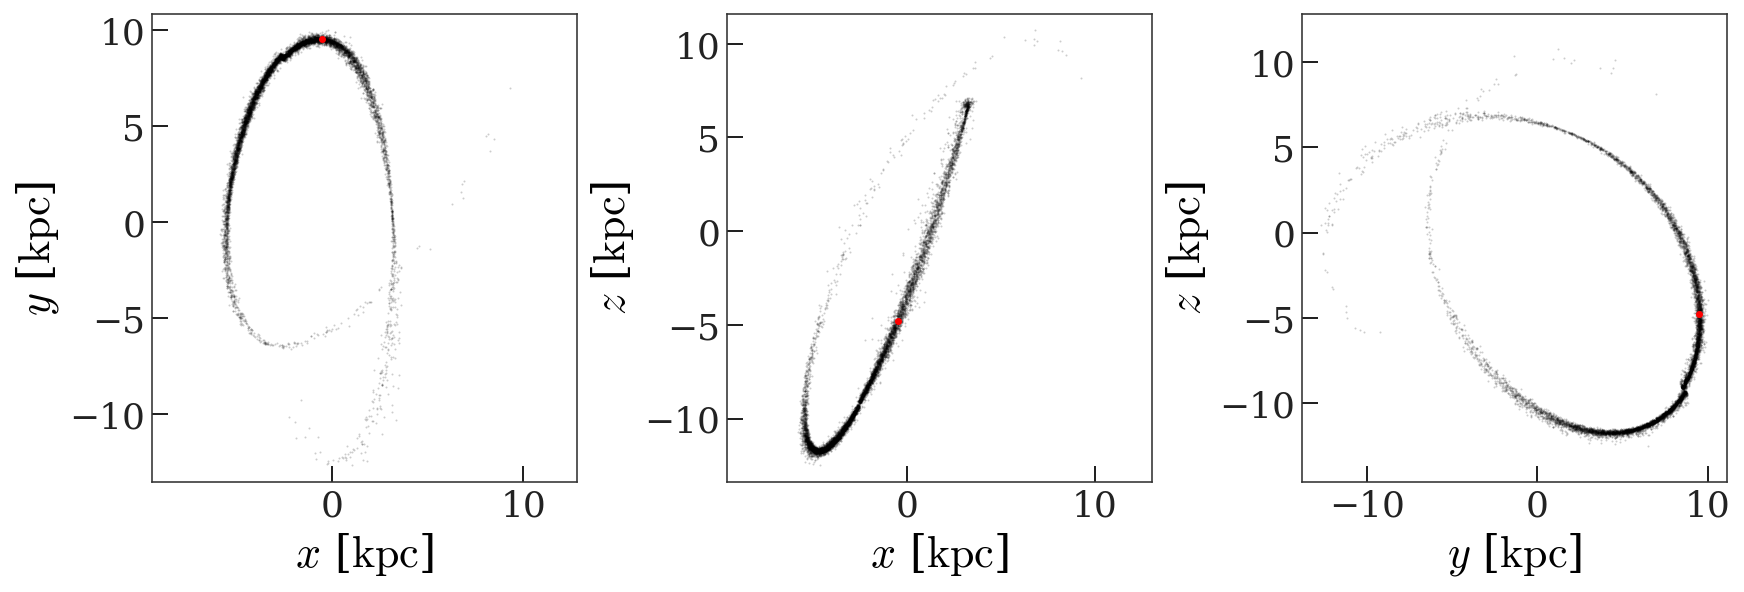

In [104]:
stream_style = dict(marker="o", ms=1.0, ls="none", alpha=0.2, plot_function=plt.plot)
fig = init_stream.plot(**stream_style)
impact_site.plot(color="r", axes=fig.axes, autolim=False, zorder=100);

In [ ]:
init_prog.to

In [ ]:
impact_site_at_impact = sim.H.integrate_orbit(
    impact_site,
    dt=-sim.dt,
    t1=sim.t_pre_impact + sim.t_post_impact,
    t2=sim.t_pre_impact,
    Integrator=gi.DOPRI853Integrator,
)[-1]

In [ ]:
subhalo_w0 = sss.get_subhalo_w0(
    impact_site_at_impact, b=impact_b, phi=phi, vphi=vphi, vz=vz
)

# Compute "buffer" time duration and timestep
# Buffer time is 32 times the crossing time:
BUFFER_N = 32
subhalo_dv = np.linalg.norm(subhalo_w0.v_xyz - impact_site.v_xyz)
subhalo_dx = np.max(u.Quantity([impact_b, c_subhalo]))

# Minimum buffer time = 20 Myr
t_buffer_impact = np.round(
    (BUFFER_N * subhalo_dx / subhalo_dv).to(u.Myr), decimals=0
)
t_buffer_impact = np.max(u.Quantity([t_buffer_impact, 20 * u.Myr]))

# Minimum buffer time step = 0.05 Myr
impact_dt = np.round((t_buffer_impact / 256).to(u.Myr), decimals=1)
impact_dt = np.max(u.Quantity([impact_dt, 0.05 * u.Myr]))

print(
    f"[{i}]: starting simulation: "
    + f"{subhalo_w0}, {t_buffer_impact=:.3f}, {impact_dt=:.3f}"
)
time0 = time.time()
stream, _, final_prog, final_t = sim.run_perturbed_stream(
    subhalo_w0, subhalo_potential, t_buffer_impact, impact_dt
)

# LMC